# Association

This model uses the concepts of bipartite graph projection and associations from Network Analytics to make restaurant recommendations.

1. For each user in the training set, look only at where they've been in Singapore. Create clusters based on this.
2. For each cluster, make recommendations of the top restaurants users in that cluster have been to.
3. For each user in the testing set, count how many associations they have to that cluster based on common restaurants overseas.

## Data Prep

In [44]:
import pickle
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [197]:
food = pd.read_csv("data/food.csv")
restaurants = pd.read_csv("data/restaurants.csv")

# combine and remove duplicates
business = pd.concat([food,restaurants])
business = business.drop_duplicates(subset = 'id', keep = 'first').name.unique()
business[0:5]

array(['Tian Tian Hainanese Chicken Rice', 'Maxwell Food Centre',
       'Jumbo Seafood', 'Song Fa Bak Kut Teh 松發 肉骨茶',
       'Lau Pa Sat Festival Market'], dtype=object)

In [3]:
# read in reviews
datafile = open("reviews.pkl", "rb")
df_reviews = pickle.load(datafile)
datafile.close()
df_reviews.head()

,business_address,business_id,business_name,cool,funny,rating,review_id,singapore_flag,text,useful,user_id
0,"54 Shoreline CirIncline Village, NV 89451",WChhuvV8Kc8xwLZiQkik4A,Daisy Day Care,0,0,5.0,Qvltfxy80b_147zraCbBGQ,0,I used Daisy Day Care last Friday with my 1 ye...,0,LkyT0hPUs_47mCtS4MQs3Q
1,"3821 N Narragansett AveChicago, IL 60634",g591dkunZTWfij-y85AFsw,Echo Limousine,1,1,5.0,eINK_4WAslLZULaKbNicVw,0,We recently used Echo Limousine to get from th...,1,LkyT0hPUs_47mCtS4MQs3Q
2,Calle los Palmitos 335290 San Bartolome de Tir...,LxhCSu0FvnDjiotkMzf53A,Aqualand Maspalomas,1,0,2.0,ppwQaxai_Ewb97J3KKwQhQ,0,Short story: this is a water park. That means ...,0,LkyT0hPUs_47mCtS4MQs3Q
3,"Avenida Los Canarios, 2735120 ArguineguinSpain",np0BG0KgxSu--e6NX7Aymw,Restaurant Valentino,0,0,5.0,S7xBOJqnNG4vPN8n2HaNJg,0,We had a really nice dinner here last night. T...,0,LkyT0hPUs_47mCtS4MQs3Q
4,"4134 Geary BlvdSan Francisco, CA 94118",_BzWIbtbJV5gzqEbZ2DjPg,Overtime Sports Bar & Restaurant - CLOSED,2,0,5.0,HizKwTg4v4R5xc5fznkeDQ,0,Awesome spot! Much needed addition to the neig...,0,LkyT0hPUs_47mCtS4MQs3Q


In [4]:
userswithreview = list(df_reviews.user_id.unique())

# read in users
datafile = open("user_info.pkl", "rb")

df_user = pickle.load(datafile)
datafile.close()

df_user = df_user[df_user.user_id.isin(userswithreview)]

df_user.head()

,elite_status,friend_count,friends,location,name,review_count,user_id
0,0.0,57.0,"[LZmKJIj_EVyrspkpII7stg, y0DE2C7GwxYU9gOIlj69V...","Geylang, Singapore, Singapore",Paul L.,4.0,ccROBnsVV5E1jxBfr7XReg
1,1.0,10.0,"[0wBI9RiVyf9HnL1IuGCCUw, cU7ysY41qGppbw4pQgjqg...","Boston, MA",Christine W.,39.0,kMGE7cs1qQAIr2gyQMmWkQ
2,1.0,140.0,"[-nQfkQuRfX2qLX-3gbgX9g, GHkLufp4_N6pwyGR9PRAm...","San Jose, CA",Ellen S.,339.0,PK4F1LiBh_x1LPbTMFmByw
3,0.0,2.0,"[L0Sq7gVgSlwGuxxAFwNmjA, Uce419ATf8Ytal3lUpmjMQ]","South Loop, Chicago, IL",Michelle N.,28.0,MszVzakDJlDQNRPDUZMtXg
4,0.0,101.0,"[3VSljYsKVX8oWSHR3HuH3Q, ChSHPHX2RMIvj2lKhM6C3...","Singapore, Singapore","Camy ""gimmycamy"" T.",142.0,W8vFfu8VMe9EAhDcphjDuQ


In [18]:
#split singaporean nonsingaporean

df_local = df_user[df_user['location'].str.contains("Singapore")]

df_tourist = df_user[~df_user['location'].str.contains("Singapore")]

print("%d locals and %d foreigners" % (len(df_local), len(df_tourist)))

tourist_ids = df_tourist['user_id'].values

train_ids, test_ids = train_test_split(tourist_ids, test_size = 0.3, random_state = 0)

print("Test set has %d ids and train set has %d" % (len(test_ids), len(train_ids)))

# train IDs and singapore IDs

train_ids_full = list(df_local['user_id']) + list(train_ids)

380 locals and 1165 foreigners
Test set has 350 ids and train set has 815


In [198]:
# seeing where people went in sg

sg_reviews = df_reviews[df_reviews.singapore_flag == 1][['business_name','user_id', 'rating']]
sg_reviews = sg_reviews[sg_reviews.business_name.isin(business)]

## Data for Clustering

In [36]:
# get the reviews of train set in singapore

reviews_train_sg = df_reviews[(df_reviews.user_id.isin(train_ids_full)) & (df_reviews.singapore_flag == 1) & (df_reviews.business_name.isin(business))][['user_id', 'business_name', 'rating']]

In [25]:
reviews_train_sg.head()

,user_id,business_name,business_id,rating
29,LkyT0hPUs_47mCtS4MQs3Q,Chinatown Complex Market & Food Centre,FDJTfKZi0zF3QNAN5nxyFw,5.0
30,LkyT0hPUs_47mCtS4MQs3Q,Newton Food Centre,tPjW88Z9NvJivI_Yyqpiag,3.0
313,A_TznMSVvVb6tbiGSvRQ_Q,Maxwell Food Centre,hQvMtUv0jTVwR6Uk3JTwNQ,4.0
314,A_TznMSVvVb6tbiGSvRQ_Q,Tian Tian Hainanese Chicken Rice,ur6Ud8Tm8xJZYjUi-1dB1A,4.0
825,TJjnjHuODSD69T7SxnB1og,8 Korean BBQ,u9car543WjG1EUobLcuKgw,2.0


In [152]:
sg_reviews_count = reviews_train_sg.groupby('user_id').size().reset_index(name = 'count')

# filter out anyone with less than 2 reviews in SG
reviewcount_ids = sg_reviews_count[sg_reviews_count['count']>3]['user_id'].values

In [153]:
reviews_train_sg = reviews_train_sg[reviews_train_sg['user_id'].isin(reviewcount_ids)]

reviews_matrix = reviews_train_sg.pivot_table(index='user_id', columns='business_name', fill_value=0, aggfunc = np.size)

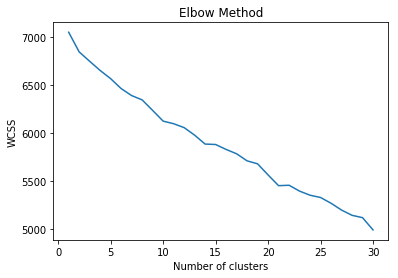

In [319]:
wcss = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(reviews_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [169]:
nclusters = 20

kmeans = KMeans(n_clusters=nclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(reviews_matrix)

train_cluster = kmeans.fit_predict(reviews_matrix)
train_cluster = pd.DataFrame(reviews_train_sg.user_id.unique(), train_cluster).reset_index()

train_cluster.columns = ['cluster', 'user_id']

In [160]:
# count how many people in each cluster

train_cluster.groupby('cluster').size()

cluster
0      54
1       1
2     324
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11     13
12      1
13     15
14      1
15      1
16      1
17      1
18     11
19      1
dtype: int64

In [312]:
# make recommendations

def make_rec(df, nclusters, numrecs):

    dict_rec = {}

    for i in range(0,nclusters):
        cluster_ids = df[df['cluster'] == i]['user_id'].values
        cluster_rec = sg_reviews[sg_reviews['user_id'].isin(cluster_ids)].groupby('business_name').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).head(numrecs)
            
        # changing to rank popularity as a function of # reviews and reivew stars
        #cluster_rec = sg_reviews[sg_reviews['user_id'].isin(cluster_ids)].groupby('business_name').agg({'user_id':'size', 'rating':'mean'}).rename(columns={'user_id':'count','rating':'avg_rating'}).reset_index()
        #scaler = MinMaxScaler()
        #cluster_rec['count_scaled'] = scaler.fit_transform(cluster_rec[['count']])
        #cluster_rec['score'] = cluster_rec['count_scaled'] * cluster_rec['avg_rating']
        #cluster_rec = cluster_rec.sort_values(by = 'score', ascending = False).head(numrecs)
            
        dict_rec[i] = list(cluster_rec.business_name.values)
        
    defaultrec = sg_reviews[sg_reviews['user_id'].isin(train_ids_full)].groupby('business_name').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).head(numrecs)

    dict_rec['Default'] = list(defaultrec.business_name.values)
    
    return dict_rec

In [209]:
# count how many correct for given number of recommendations
def count_acc(recs, pred):

    correct_rec = 0

    for i in range(len(test_ids)):
        user = test_ids[i]
        cluster = pred[i]

        # for the given user, find the restaurants they visited in sg
        visitedrest = df_reviews[(df_reviews['user_id'] == user) & (df_reviews['singapore_flag'] == 1)]['business_name'].values

        count = 0

        for i in visitedrest:
            if i in recs[cluster]:
                count = 1

        correct_rec += count

    acc = correct_rec / len(test_ids)
    
    return acc

In [301]:
# function to predict which cluster a user belongs to
def make_pred(df, nclusters):

    pred_cluster = []

    for testid in test_ids:

        # for each person in the test set, find their reviews
        test_reviews = df_reviews[(df_reviews.user_id == testid) & (df_reviews.singapore_flag == 0)]
        test_reviews = test_reviews['business_name'].unique()

        assoc_dict = {}

        for cluster in range(0,nclusters):
            # filter train reviews to the cluster
            cluster_ids = df[df.cluster == cluster]['user_id']
            train_reviews_overseas = df_reviews[(df_reviews.user_id.isin(cluster_ids)) & (df_reviews.singapore_flag == 0)]
            train_reviews_overseas = train_reviews_overseas[['user_id', 'business_name']].drop_duplicates()

            #count associations
            count = 0
            for business in train_reviews_overseas['business_name']:
                if business in test_reviews:
                    count += 1

            # add to dictionary
            assoc_dict[cluster] = count
            
        # if there's no association, give them a default
        if max(assoc_dict.values()) == 0:
            pred_value == 'Default'
            
        else:
            pred_value = [key  for (key, value) in assoc_dict.items() if value == max(assoc_dict.values())][0]

        # assign cluster based off number of associations
        pred_cluster.append(pred_value)
    
    return(pred_cluster)

In [294]:
# list of their friends

def make_pred_friends(df, nclusters):
    pred_cluster = []
    
    for test in test_ids:

        test_friends = df_user[df_user.user_id == test]['friends'].values[0]

        assoc_dict = {}

        for cluster in range(0,nclusters):

            cluster_ids = df[df.cluster == cluster]['user_id'].values

            assoc_count = 0

            # count number of mutual friends
            for train in cluster_ids:
                if train not in test_friends:
                    train_friends = df_user[df_user.user_id == train]['friends'].values[0]

                    for mutual_friend in train_friends:
                        if mutual_friend in test_friends:
                            assoc_count += 1

            assoc_count

            # add to dictionary:
            assoc_dict[cluster] = assoc_count

        pred_value = [key  for (key, value) in assoc_dict.items() if value == max(assoc_dict.values())][0]

        # assign cluster based off number of associations
        pred_cluster.append(pred_value)
    
    return(pred_cluster)

In [291]:
for i in range(0, len(pred_places)):
    if pred_places[i] != pred_mutualfriends[i]:
        print(test_ids[i])

In [218]:
#takes dataframe that assigns train set to certain clusters
# outputs the accuracy of predictions on dataset for 1-30 recommendations

def acc_dataframe(train_cluster, nclusters):
    pred_cluster = make_pred(train_cluster, nclusters)
    
    # create a blank dataframe to input the results
    df = pd.DataFrame(columns=['rank', 'testinclusion'])

    for numrecs in range(0,31):

        recs = make_rec(train_cluster, nclusters, numrecs)
        acc = count_acc(recs, pred_cluster)

        df = df.append({'rank': numrecs, 'testinclusion': acc}, ignore_index=True)

    return df

In [343]:
reviews_matrix_ids = reviews_matrix.reset_index().user_id.values

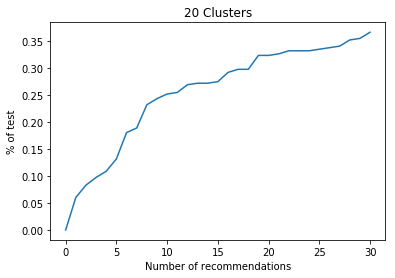

In [344]:
nclusters = 20

kmeans = KMeans(n_clusters=nclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(reviews_matrix)

train_cluster_20 = kmeans.fit_predict(reviews_matrix)
train_cluster_20 = pd.DataFrame(reviews_matrix_ids, train_cluster_20).reset_index()
train_cluster_20.columns = ['cluster', 'user_id']

cluster_20 = acc_dataframe(train_cluster_20, nclusters)

plt.plot(cluster_20['rank'], cluster_20['testinclusion'])
plt.title('20 Clusters')
plt.xlabel('Number of recommendations')
plt.ylabel('% of test')
plt.show()

In [352]:
cluster_20

,rank,testinclusion
0,0.0,0.000000
1,1.0,0.060000
2,2.0,0.082857
3,3.0,0.097143
4,4.0,0.108571
5,5.0,0.131429
6,6.0,0.180000
7,7.0,0.188571
8,8.0,0.231429
9,9.0,0.242857
